In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn.datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn.functional import normalize
from torch.nn import Module
from typing import Any, Optional, TypeVar
import math
import copy

In [2]:
np.random.seed(0)
torch.manual_seed(0)

### Setup

In [3]:
# Define visulization macors

plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

### The two moon dataset

In [4]:
def make_training_data(sample_size = 500):

    # Create two moon Training dataset
    train_examples, train_labels = sklearn.datasets.make_moons(n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return torch.tensor(train_examples, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32)

def make_testing_data(x_range = DEFAULT_X_RANGE, y_range = DEFAULT_Y_RANGE, n_grid = DEFAULT_N_GRID):

    # Create a mesh grid in 2D space
    # Testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)

    return torch.stack([torch.tensor(xv.flatten(), dtype=torch.float32), torch.tensor(yv.flatten(), dtype=torch.float32)], axis=-1)

def make_ood_data(sample_size = 500, means = (2.5, -1.75), vars = (0.01, 0.01)):
    return torch.tensor(np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size), dtype=torch.float32)

In [5]:
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

In [6]:
print(train_examples.shape)
print(train_labels.shape)
print(test_examples.shape)
print(ood_examples.shape)

torch.Size([1000, 2])
torch.Size([1000])
torch.Size([10000, 2])
torch.Size([500, 2])


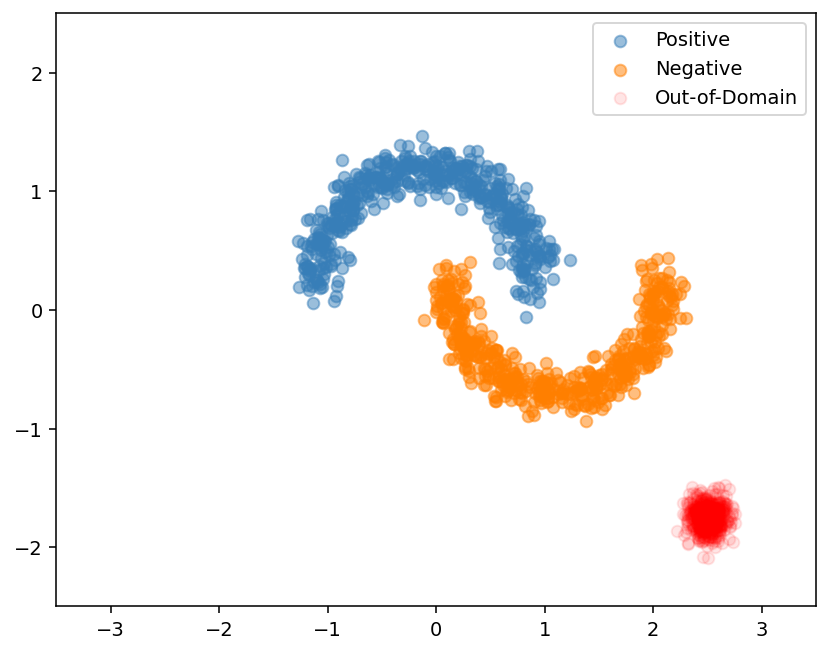

In [7]:
# Visualize
pos_examples = train_examples[train_labels == 0].detach().numpy()
neg_examples = train_examples[train_labels == 1].detach().numpy()

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Positive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

### Deterministic: Deep Resnet Architecture with Fully-Connected Layers

In [9]:
class DeepResnet(nn.Module):
    def __init__(self, num_inputs_features, num_layers, num_hidden, dropout_rate, num_outputs):
        super().__init__()
        
        self.num_inputs_features = num_inputs_features
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.dropout_rate = dropout_rate
        self.num_outputs = num_outputs

        '''Define structures'''
        # Input Layer
        self.input_layer = nn.Linear(num_inputs_features, num_hidden)

        # Hidden Layers
        self.linears = nn.ModuleList(
            [nn.Linear(num_hidden, num_hidden) for i in range(num_layers)]
            )
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # Output
        self.classifier = nn.Linear(num_hidden, num_outputs)

    def forward(self, inputs):

        # 1st hidden layer by feeding input data to the neural net
        hidden = self.input_layer(inputs)

        # Compute Resnet hidden layers and return output layer
        for resid in self.linears:
            hidden = hidden + self.dropout(F.relu(resid(hidden)))

        out = self.classifier(hidden)

        return out

### Train the model

In [10]:
resnet_model = DeepResnet(num_inputs_features=2, num_layers=6, num_hidden=128, dropout_rate=0.01, num_outputs=1)

In [11]:
# According to the tensorflow implementation, the first layer is frozen
for param in resnet_model.input_layer.parameters():
    param.requires_grad = False

In [12]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)
num_epochs = 100
batch_size = 128

In [13]:
dataset = data.TensorDataset(train_examples, train_labels)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [14]:
for epoch in range(num_epochs):
    losses = []
    accs = []
    print("\n- epoch: {}/{}".format(epoch+1, num_epochs))
    for samples in dataloader:
        x_train, y_train = samples    
        
        probabilities = torch.sigmoid(resnet_model(x_train)).squeeze()
        loss = loss_function(probabilities, y_train)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predictions = (probabilities > 0.5).float()
        num_correct = (predictions == y_train).float()
        accs.append(torch.mean(num_correct))
    
    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(accs) / len(accs)

    print(f"average loss: {avg_loss:.4f}")
    print("average accuracy: ", avg_acc)


- epoch: 1/100
average loss: 0.6951
average accuracy:  tensor(0.5747)

- epoch: 2/100
average loss: 0.4163
average accuracy:  tensor(0.9247)

- epoch: 3/100
average loss: 0.2762
average accuracy:  tensor(0.9361)

- epoch: 4/100
average loss: 0.2014
average accuracy:  tensor(0.9464)

- epoch: 5/100
average loss: 0.1588
average accuracy:  tensor(0.9549)

- epoch: 6/100
average loss: 0.1320
average accuracy:  tensor(0.9549)

- epoch: 7/100
average loss: 0.1136
average accuracy:  tensor(0.9627)

- epoch: 8/100
average loss: 0.1005
average accuracy:  tensor(0.9642)

- epoch: 9/100
average loss: 0.0911
average accuracy:  tensor(0.9696)

- epoch: 10/100
average loss: 0.0831
average accuracy:  tensor(0.9769)

- epoch: 11/100
average loss: 0.0755
average accuracy:  tensor(0.9781)

- epoch: 12/100
average loss: 0.0716
average accuracy:  tensor(0.9810)

- epoch: 13/100
average loss: 0.0660
average accuracy:  tensor(0.9808)

- epoch: 14/100
average loss: 0.0637
average accuracy:  tensor(0.9803)



### Visualize the Class Probability and the Predictive Uncertainty of the Deterministic Model

In [15]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
    """ 
    Arguments:
        test_uncertainty: Array of uncertainty scores, shape (num_test, ).
        ax: A matplotlib Axes object that specifies a matplotlib figure.
        cmap: A matplotlib colormap object specifying the palette of the predictive surface. 

    Returns:
        pcm: A matplotlib PathCollection object that contains the palette information of the uncertainty plot.
    """
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / torch.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
        np.reshape(test_uncertainty.detach().numpy(), [DEFAULT_N_GRID, DEFAULT_N_GRID]),
        cmap=cmap,
        origin="lower",
        extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
        vmin=DEFAULT_NORM.vmin,
        vmax=DEFAULT_NORM.vmax,
        interpolation='bicubic',
        aspect='auto')

    # Plot training data.
    ax.scatter(train_examples[:, 0], train_examples[:, 1], c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
    ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm

In [16]:
# Now visualize the predictions of the deterministic model. First plot the class probability
resnet_logits = resnet_model(test_examples)
resnet_probs = 1-torch.sigmoid(resnet_logits) # Take the probability for class 0

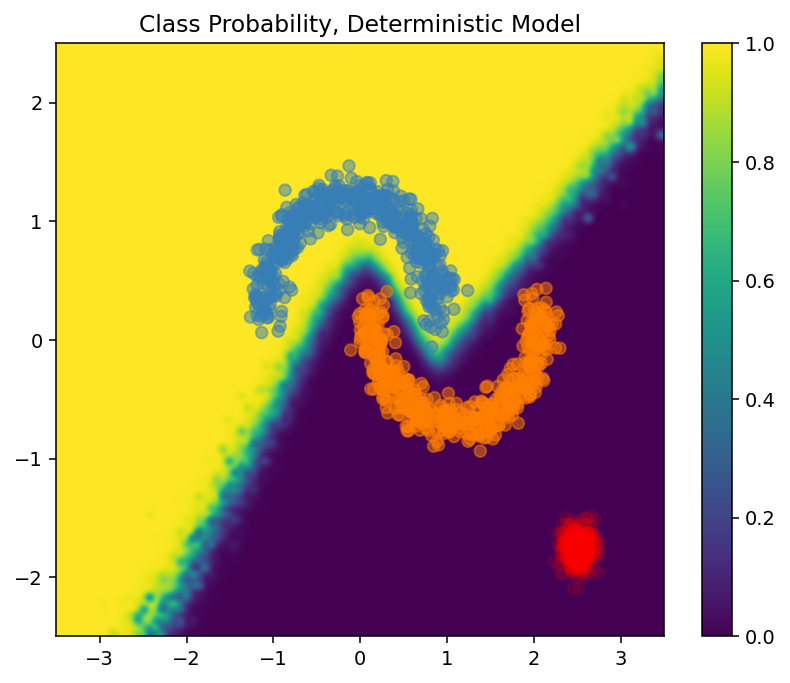

In [17]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

Problem: This model classifies the OOD instances as the orange class

In [18]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

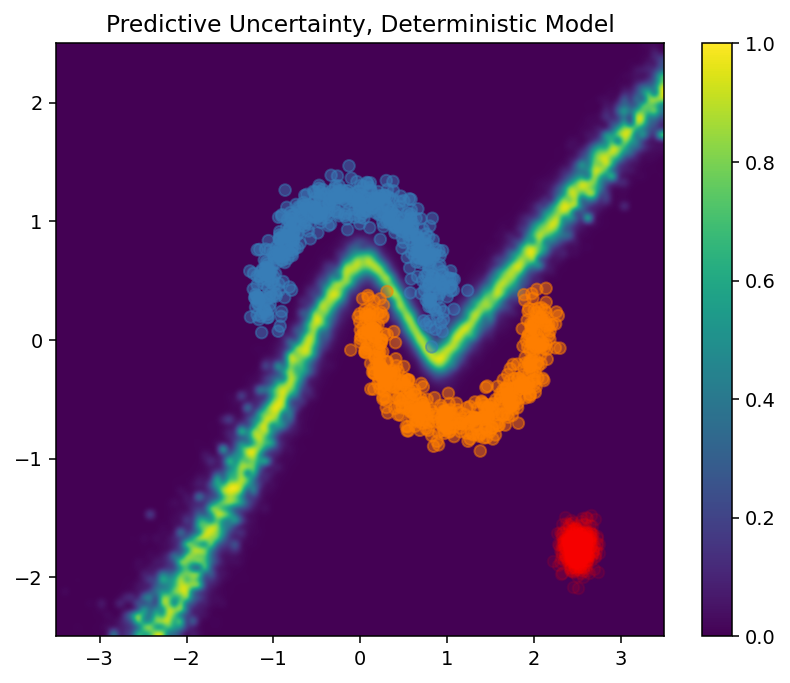

In [19]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

Yellow: High Uncertainty <br>
Purple: Low Uncertainty <br>
The uncertainty of a deterministic fc_resnet depends only on the distance from test instances to the decision boundary. <br>
-> the model performs overconfidently for ood samples.